In [1]:
"""
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
"""

'\n# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python\n# For example, here\'s several helpful packages to load\n\nimport numpy as np # linear algebra\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" \n# You can also write temporary files to /kaggle/temp/, but they won\'t be saved outside of the current session\n'

In [1]:
import pandas as pd
import numpy as np

In [6]:
# Basic data loading
path = "data/"

df_train = pd.read_csv(path + 'sales_train.csv')
df_test = pd.read_csv(path + 'test.csv', index_col='ID')
df_shops = pd.read_csv(path + 'shops.csv', index_col='shop_id')
df_items = pd.read_csv(path + 'items.csv', index_col='item_id')
df_itemcat = pd.read_csv(path + 'item_categories.csv', index_col='item_category_id')
sample_submission = pd.read_csv(path + 'sample_submission.csv', index_col='ID')

In [7]:
# https://www.kaggle.com/karanjakhar/simple-and-easy-aprroach-using-lstm 참고

def basic_eda(df):
    print("----------DISPLAY--------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("-------Missing Values----------")
    print(df.isnull().sum())
    print("-------NULL values-------------")
    print(df.isna().sum())
    print("-----Shape Of Data-------------")
    print(df.shape)

In [8]:
print("=============================Sales Data=============================")
basic_eda(df_train)
print("=============================Test data=============================")
basic_eda(df_test)
print("=============================Item Categories=============================")
basic_eda(df_itemcat)
print("=============================Items=============================")
basic_eda(df_items)
print("=============================Shops=============================")
basic_eda(df_shops)
print("=============================Sample Submission=============================")
basic_eda(sample_submission)

=============================Sales Data=============================
----------DISPLAY--------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
----------Descri

In [9]:
## date를 datetime 데이터로 바꿔봅시다.

from datetime import datetime

datetime_str = "02.01.2013"
datetime_object = datetime.strptime(datetime_str, "%d.%m.%Y")
print(type(datetime_object))
print(datetime_object)  # printed in default format
print(datetime_object.year)
print(datetime_object.month)
print(datetime_object.day)

<class 'datetime.datetime'>
2013-01-02 00:00:00
2013
1
2


In [10]:
display(df_train)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## 전처리를 통해 시각화용 자료를 만들어봅시다.

In [11]:
# 우선 훈련데이터에서 테스트데이터와 공통된 데이터만을 남겨봅시다.
# 테스트데이터에는 ID, shop_id, item_id만이 있습니다. --> train에는 ID가 없으니 제외합니다.
# 각 컬럼별로 전처리를 진행합니다!

# train데이터 중 test데이터에 있는 shop_id만 남깁니다.
df_test_shops = df_test.shop_id.unique()
df_train = df_train[df_train.shop_id.isin(df_test_shops)]
print("shop_id 전처리 후 :",df_train.shape) # 2935849 -> 2413246

# train데이터 중 test데이터에 있는 item_id만 남깁니다.
df_test_items = df_test.item_id.unique()
df_train = df_train[df_train.item_id.isin(df_test_items)]
print("item_id 전처리 후 :",df_train.shape) # 2413246 -> 1224439

shop_id 전처리 후 : (2413246, 6)
item_id 전처리 후 : (1224439, 6)


In [12]:
from sklearn.preprocessing import LabelEncoder

# date 컬럼을 연, 월, 일 컬럼으로 나눈다.
def date_processing(df):
    df["date"] = df["date"].apply(lambda date_str : datetime.strptime(date_str, "%d.%m.%Y"))
    df["year"] = df["date"].apply(lambda date : date.year)
    df["month"] = df["date"].apply(lambda date : date.month)
    df["day"] = df["date"].apply(lambda date : date.day)
    df = df.drop(columns=["date"]) # date 컬럼을 버린다.
    df = df[["date_block_num","year", "month","day", "shop_id", "item_id", "item_price", "item_cnt_day"]] # df 컬럼 조정
    return df

# shop_id와 item_id는 카테고리, 이를 수치형으로 변환시킨다?? --> 중간중간에 비어있는 id를 다시 조정
def encode_label(df):
    encode_cols = ["shop_id", "item_id"]
    encoders = []
    for col in encode_cols:
        enc = LabelEncoder() # 카테고리형을 수치로 변환
        df[col] = enc.fit_transform(df[col]) # 변환한 데이터를 다시 넣는다.
        encoders.append(enc)
    return df, encoders

# 두 함수를 합쳐서 수행하는 함수
def preprosessing_simple(df):
    df = df.copy() # 복사한 데이터를 이용한다.
    df = date_processing(df) # date를 전처리한다.
    df, encoders = encode_label(df) # 각 id를 다시 encoding한다.
    return df, encoders

df_train_processed, encoders = preprosessing_simple(df_train)
df_train_processed.head() # 전처리한 데이터

,date_block_num,year,month,day,shop_id,item_id,item_price,item_cnt_day
0,0,2013,1,2,41,4710,999.0,1.0
10,0,2013,1,3,16,461,399.0,2.0
11,0,2013,1,5,16,461,399.0,1.0
12,0,2013,1,7,16,461,399.0,1.0
13,0,2013,1,8,16,461,399.0,2.0


In [13]:
# 원래 shop_id와 변환된 shop_id 비교
print("inverse trasform of encoded shop_id : ", encoders[0].inverse_transform(df_train_processed["shop_id"]))
df_train_processed["shop_id"].values

inverse trasform of encoded shop_id :  [59 25 25 ... 25 25 25]


array([41, 16, 16, ..., 16, 16, 16])

In [14]:
df_train_processed.info() # 전처리 된 데이터 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224439 entries, 0 to 2935848
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date_block_num  1224439 non-null  int64  
 1   year            1224439 non-null  int64  
 2   month           1224439 non-null  int64  
 3   day             1224439 non-null  int64  
 4   shop_id         1224439 non-null  int64  
 5   item_id         1224439 non-null  int64  
 6   item_price      1224439 non-null  float64
 7   item_cnt_day    1224439 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 84.1 MB


# 시각화를 통한 접근을 해봅시다.

### 시각화를 통해 알고 싶은 것
1. 시계열 변화를 통한 판매량 변화

,date_block_num,year,month,day,shop_id,item_id,item_price,item_cnt_day
0,0,2013,1,2,41,4710,999.0,1.0
10,0,2013,1,3,16,461,399.0,2.0
11,0,2013,1,5,16,461,399.0,1.0
12,0,2013,1,7,16,461,399.0,1.0
13,0,2013,1,8,16,461,399.0,2.0
...,...,...,...,...,...,...,...,...
2935844,33,2015,10,10,16,1574,299.0,1.0
2935845,33,2015,10,9,16,1579,299.0,1.0
2935846,33,2015,10,14,16,1578,349.0,1.0
2935847,33,2015,10,22,16,1575,299.0,1.0


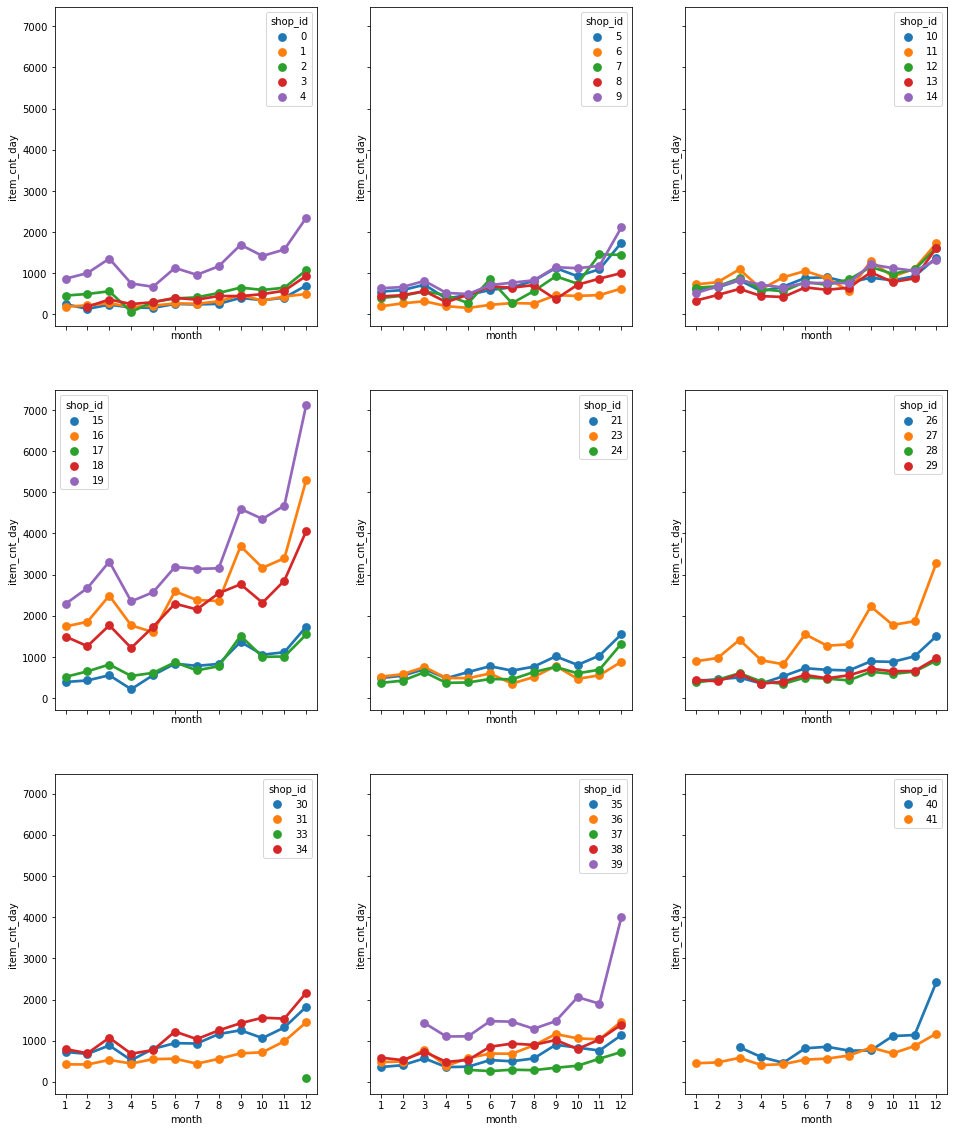

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import warnings
warnings.filterwarnings(action='ignore')


# 시각화를 어떻게 해야 하나
train = df_train_processed.copy()
display(train)


# 훈련데이터 중에서 shop_id 컬럼과 year, month를 기준으로 묶은 뒤, item_cnt_dat를 모두 더합니다. 그 뒤 인덱스를 리셋합니다.
def group(df, year=2013) :
    grouped = pd.DataFrame(df.groupby(['shop_id', 'year', 'month'])['item_cnt_day'].sum().reset_index())
    grouped = grouped.groupby(['year']).get_group(year)
    return grouped

grouped = group(train,2013)

# 2013년 그래프를 그려봅시다!! 
# shop을 기준으로 그립니다!!
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph) # 이것의 의미?? 특정 범위를 한정하는 것 같은데 나중에 자세히 보자.
count = 0 # 순서 넘어갈 때 인덱스로 사용


# 아까와 동일하게 그린다. 
# 다만 시간대는 x축은 momth로 주고, y축은 일일 판매량 그대로이다. 데이터는 가게 아이디로 한다.
for i in range(3):
    for j in range(3):
        sns.pointplot(x='month', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1


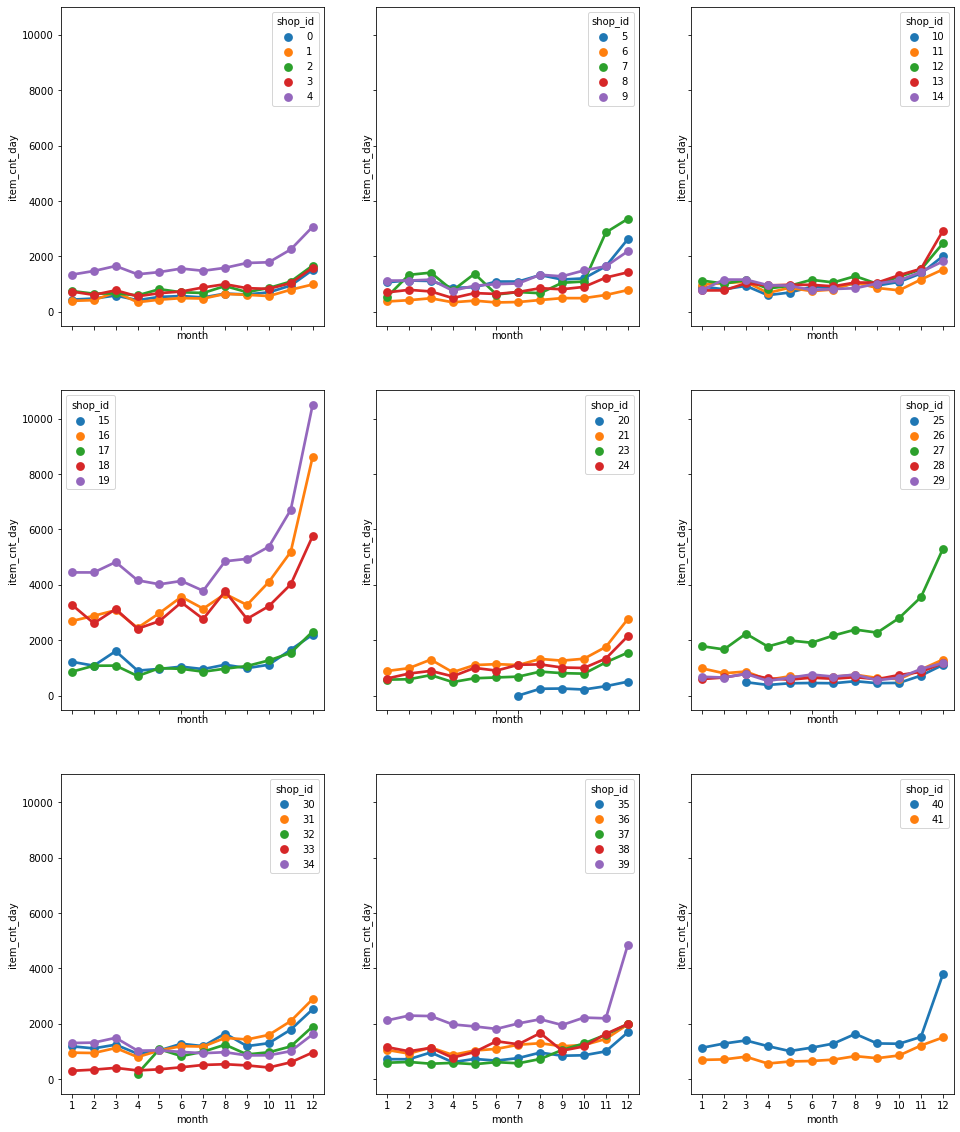

In [16]:
# 2014년 그래프를 그려봅시다!! 
grouped = group(train,2014)

# shop을 기준으로 그립니다!!
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph) # 이것의 의미?? 특정 범위를 한정하는 것 같은데 나중에 자세히 보자.
count = 0 # 순서 넘어갈 때 인덱스로 사용


# 아까와 동일하게 그린다. 
# 다만 시간대는 x축은 momth로 주고, y축은 일일 판매량 그대로이다. 데이터는 가게 아이디로 한다.
for i in range(3):
    for j in range(3):
        sns.pointplot(x='month', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

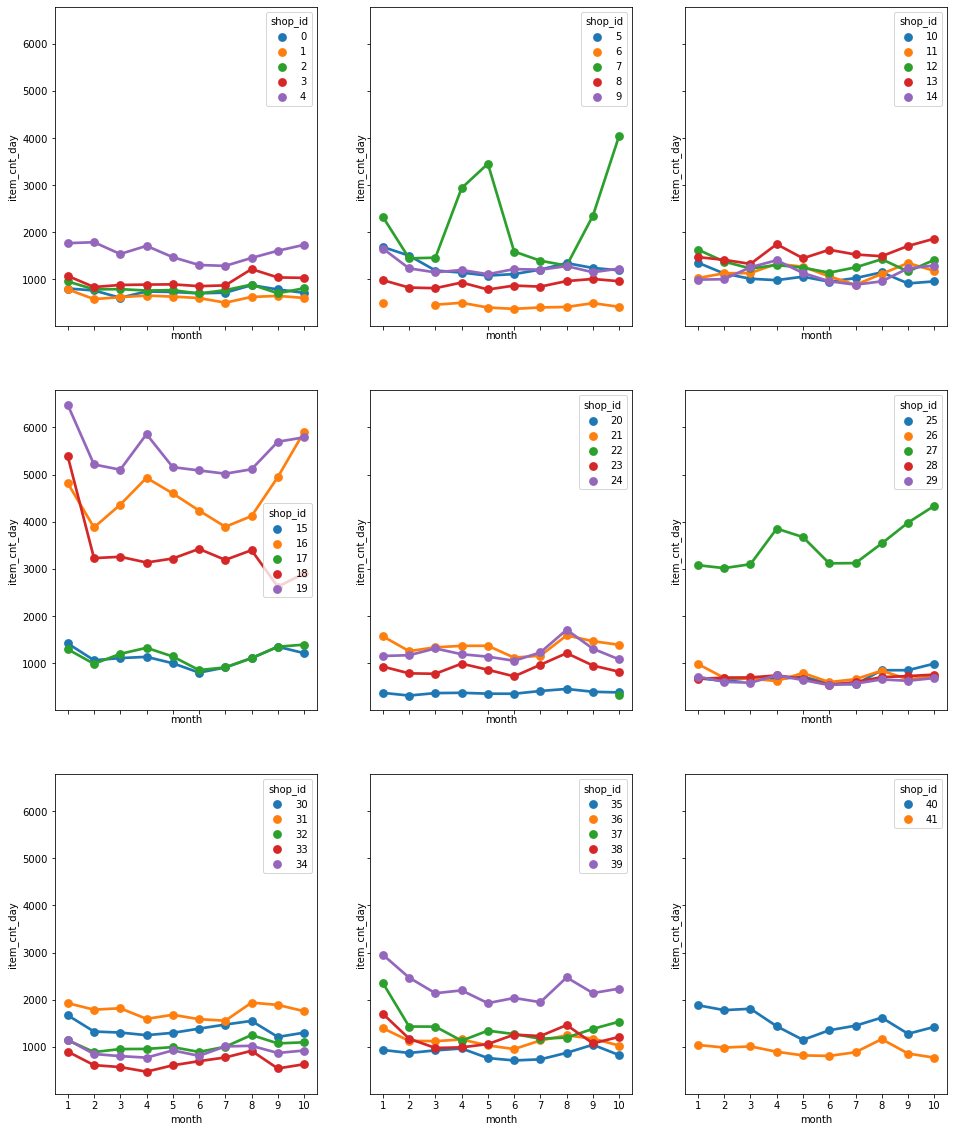

In [26]:
# 2015년 그래프를 그려봅시다!! 
grouped = group(train,2015)

# shop을 기준으로 그립니다!!
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph) # 이것의 의미?? 특정 범위를 한정하는 것 같은데 나중에 자세히 보자.
count = 0 # 순서 넘어갈 때 인덱스로 사용


# 아까와 동일하게 그린다. 
# 다만 시간대는 x축은 momth로 주고, y축은 일일 판매량 그대로이다. 데이터는 가게 아이디로 한다.
for i in range(3):
    for j in range(3):
        sns.pointplot(x='month', y='item_cnt_day', hue='shop_id', 
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

## 시각화 인사이트

12월 혹은 연초에 급격하게 판매량이 증가하는 경우가 발생 (크리스마스 등의 행사인 듯)      
이를 제거하고 나머지 데이터로만 접근하는 것이 평달의 판매량을 추측하는 것에 도움이 될 듯하다.    

# 여기까지가 EDA 입니다.

# 아래부터는 모델 학습 및 예측입니다.

In [27]:
# 시각화 인사이트대로 12~3월 사이 데이터를 제거합니다.

display(df_train_processed.head())

df_train_processed = df_train_processed.

,date_block_num,year,month,day,shop_id,item_id,item_price,item_cnt_day
0,0,2013,1,2,41,4710,999.0,1.0
10,0,2013,1,3,16,461,399.0,2.0
11,0,2013,1,5,16,461,399.0,1.0
12,0,2013,1,7,16,461,399.0,1.0
13,0,2013,1,8,16,461,399.0,2.0


# 날짜, 가게아이디, 물품아이디로 물품 가격 학습, 예측하기

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
random_state = 200

price_X = df_train_processed.iloc[:,:5] # year, month, day, shop_id, item_id
price_y = df_train_processed.iloc[:,5] # item_price

# 예측하기 위함
def price_predict(model, price_x, price_y, kind="default", print_len=7):
    
    # 훈련데이터와 유효성검사 데이터로 나눈다.
    X_train, X_val, y_train, y_val = train_test_split(price_X, price_y, test_size=0.2, random_state=random_state)
    
    # 훈련시킨다.
    model.fit(X_train, y_train)
    
    # 모델평가
    y_pred_train = model.predict(X_train)
    model_name = model.__class__.__name__
    print("#### " +model_name+" price prediction("+kind+") ####")
    print("y_train[:{}] : {}".format(print_len, np.round(y_train[:print_len].values,1)))
    print("y_pred_train[:{}] : {}".format(print_len, np.round(y_pred_train[:print_len],1)))
    print()
    
    y_pred_val = model.predict(X_val)
    print("y_val[:{}] : {}".format(print_len, np.round(y_val[:print_len].values,1)))
    print("y_pred_val[:{}] : {}".format(print_len, np.round(y_pred_val[:print_len],1)))
    rmse = np.sqrt(mean_squared_error(y_pred_val, y_val))
    print("rmse : {:.6f}".format(rmse)) # 평균제곱근 편차
    print("----------\n")
    return model

In [36]:
# lGBM 모델로 예측

from lightgbm import LGBMRegressor
price_regressor = LGBMRegressor(random_state=random_state)
price_regressor = price_predict(price_regressor, price_X, price_y)

#### LGBMRegressor price prediction(default) ####
y_train[:7] : [149. 299. 249. 999. 399. 149. 399.]
y_pred_train[:7] : [343.4 345.8 461.1 386.7 370.3 352.5 594.5]

y_val[:7] : [299. 170. 899. 299. 199. 149. 199.]
y_pred_val[:7] : [496.7 410.4 803.6 663.5 923.7 387.3 336.9]
rmse : 910.932404
----------



In [37]:
# Randomforest 모델로 예측

from sklearn.ensemble import RandomForestRegressor
price_regressor = RandomForestRegressor(random_state=random_state)
price_regressor = price_predict(price_regressor, price_X, price_y)

#### RandomForestRegressor price prediction(default) ####
y_train[:7] : [149. 299. 249. 999. 399. 149. 399.]
y_pred_train[:7] : [149.  299.  244.6 999.  399.  149.  399. ]

y_val[:7] : [299. 170. 899. 299. 199. 149. 199.]
y_pred_val[:7] : [268.4 170.  899.  299.2 199.  149.  199. ]
rmse : 124.834814
----------



In [38]:
# 2015년 11월 일별 가격예측 (가게는 5이고, 물건은 5037일때)

tmp_dict = {
    "year":[2015 for i in range(1, 31)],
    "month":[11 for i in range(1, 31)],
    "day":[i for i in range(1, 31)],
    "shop_id":[5 for i in range(1, 31)],
    "item_id":[5037 for i in range(1, 31)]
}

test_df = pd.DataFrame.from_dict(tmp_dict)
test_df.head()
price_day = price_regressor.predict(test_df)
print(price_day)

[253.05 253.05 253.05 253.05 253.05 253.05 253.05 253.05 253.05 253.05
 253.05 253.05 253.05 253.05 253.05 253.05 253.05 253.05 251.22 251.22
 249.82 250.32 250.32 249.82 246.97 246.97 242.22 245.5  246.95 246.95]


In [39]:
# 2015년 월별 가격 예측 (날짜는 1로 고정, 가게는 5, 물건은 5037) 

tmp_dict = {
    "year":[2015 for i in range(1, 12)],
    "month":[i for i in range(1, 12)],
    "day":[1 for i in range(1, 12)],
    "shop_id":[5 for i in range(1, 12)],
    "item_id":[5037 for i in range(1, 12)]
}
test_df = pd.DataFrame.from_dict(tmp_dict)
test_df.head()
price_month = price_regressor.predict(test_df)
print(price_month)

[246.26 253.55 253.05 253.05 253.05 253.05 253.05 253.05 253.05 253.05
 253.05]


In [40]:
# 연별 예측 (1월 2일, 가게는 44, 물건은 2047) 

tmp_dict = {
    "year":[i for i in range(2013, 2016)],
    "month":[1 for i in range(1, 4)],
    "day":[2 for i in range(1, 4)],
    "shop_id":[44 for i in range(1, 4)],
    "item_id":[2047 for i in range(1, 4) ]
}
test_df = pd.DataFrame.from_dict(tmp_dict)
test_df.head()
print_year = price_regressor.predict(test_df)
print(print_year)

[1950.6421 1950.6421 1950.6421]


# 테스트 데이터로 2015년 11월 모든 일자 물품 가격 예측하기

In [41]:
# 예측하기 전 연,월,일을 추가해 predicted된 가격을 넣을 데이터프레임을 만들어보자

df_test["year"] = 2015
df_test["month"] = 11
df_test["day"] = 3
df_test["day"] = df_test["day"].apply(lambda x : [i for i in range(1, 32)])
df_test = df_test.explode("day")
df_test

,shop_id,item_id,year,month,day
ID,,,,,
0,5,5037,2015,11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,5,5320,2015,11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,5,5233,2015,11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,5,5232,2015,11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,5,5268,2015,11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
...,...,...,...,...,...
214195,45,18454,2015,11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
214196,45,16188,2015,11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
214197,45,15757,2015,11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [42]:
# 테스트 데이터 컬럼 순서를 바꾼 뒤, predict한다. (randomforest)
df_test = df_test[["year", "month", "day", "shop_id", "item_id"]]
price_test = price_regressor.predict(df_test)
price_test

,shop_id,item_id,year,month,day
ID,,,,,
0,5,5037,2015,11,1
0,5,5037,2015,11,2
0,5,5037,2015,11,3
0,5,5037,2015,11,4
0,5,5037,2015,11,5
...,...,...,...,...,...
214199,45,969,2015,11,26
214199,45,969,2015,11,27
214199,45,969,2015,11,28


In [43]:
# 예측한 가격을 item_price라는 컬럼에 넣는다.
df_test["item_price"] = price_test
df_test

array([253.05, 253.05, 253.05, ..., 342.06, 341.06, 340.56])

# 날짜, 가게아이디, 물품아이디, 물품 가격으로 물품 판매 갯수 학습, 예측하기

In [45]:
# 이전에 전처리했던 원형 데이터를 가져온다. -> 10퍼센트라서 2013년 데이터 
df_train_processed

,year,month,day,shop_id,item_id,item_price,item_cnt_day
0,2013,1,2,46,10003,999.00,1.0
1,2013,1,3,21,943,899.00,1.0
2,2013,1,5,21,943,899.00,-1.0
3,2013,1,6,21,945,1709.05,1.0
4,2013,1,15,21,946,1099.00,1.0
...,...,...,...,...,...,...,...
293579,2013,3,9,8,1523,299.00,1.0
293580,2013,3,24,8,1520,1649.00,1.0
293581,2013,3,24,8,1506,299.00,1.0
293582,2013,3,21,8,1461,399.00,1.0


In [46]:
# 판매개수를 예측하는 함수를 만들어봅시다.

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
random_state = 200

cnt_X = df_train_processed.iloc[:,:6]
cnt_y = df_train_processed.iloc[:,6]

def cnt_predict(model, cnt_X, cnt_y, kind="default", print_len=7):
    
    # 훈련데이터와 유효성 검사데이터로 나눈다. 
    X_train, X_val, y_train, y_val = train_test_split(cnt_X, cnt_y, test_size=0.2, random_state=random_state)
    
    # 훈련
    model.fit(X_train, y_train)
    
    # 예측
    y_pred_train = model.predict(X_train)
    model_name = model.__class__.__name__
    print("#### " +model_name+" cnt prediction("+kind+") ####")
    print("y_train[:{}] : {}".format(print_len, np.round(y_train[:print_len].values,1)))
    print("y_pred_train[:{}] : {}".format(print_len, np.round(y_pred_train[:print_len],1)))
    print()
    
    # 유효성검사 데이터로 예측
    y_pred_val = model.predict(X_val)
    print("y_val[:{}] : {}".format(print_len, np.round(y_val[:print_len].values,1)))
    print("y_pred_val[:{}] : {}".format(print_len, np.round(y_pred_val[:print_len],1)))
    rmse = np.sqrt(mean_squared_error(y_pred_val, y_val))
    print("rmse : {:.6f}".format(rmse))
    print("----------\n")
    return model

In [47]:
# 랜덤포레스트 모델로 예측합니다.

cnt_regressor = RandomForestRegressor(random_state=random_state)
cnt_regressor = cnt_predict(price_regressor, cnt_X, cnt_y)

#### RandomForestRegressor cnt prediction(default) ####
y_train[:7] : [1. 1. 1. 1. 1. 1. 1.]
y_pred_train[:7] : [1.  0.9 1.  1.  1.  1.  1. ]

y_val[:7] : [1. 1. 1. 1. 1. 1. 1.]
y_pred_val[:7] : [1.  1.  1.1 1.  1.1 1.  1. ]
rmse : 0.725827
----------



In [48]:
# 시험용 데이터로 예측해봅니다.

cnt_test = cnt_regressor.predict(df_test)
cnt_test

array([1.46, 1.47, 1.5 , ..., 1.14, 1.16, 1.09])

In [49]:
# 예측한 카운트를 data 컬럼에 넣습니다.

df_test["item_cnt_day"] = cnt_test
df_test

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,year,month,day,shop_id,item_id,item_price,item_cnt_day
ID,,,,,,,
0,2015,11,1,5,5037,253.05,1.46
0,2015,11,2,5,5037,253.05,1.47
0,2015,11,3,5,5037,253.05,1.50
0,2015,11,4,5,5037,253.05,1.46
0,2015,11,5,5,5037,253.05,1.41
...,...,...,...,...,...,...,...
214199,2015,11,26,45,969,342.36,1.01
214199,2015,11,27,45,969,353.06,1.03
214199,2015,11,28,45,969,342.06,1.14


In [50]:
# 컬럼 중 필요한 submission용 컬럼만 두고 버립니다.

cols = ["year", "month", "day", "item_price"]
final_test = df_test.drop(columns=cols)
final_test

,shop_id,item_id,item_cnt_day
ID,,,
0,5,5037,1.46
0,5,5037,1.47
0,5,5037,1.50
0,5,5037,1.46
0,5,5037,1.41
...,...,...,...
214199,45,969,1.01
214199,45,969,1.03
214199,45,969,1.14


In [51]:
# item_id가 같은 것끼리 묶습니다. 

final_test = final_test.groupby(["shop_id", "item_id"])["item_cnt_day"].sum().reset_index()
final_test = final_test.rename(columns={"item_cnt_day":"item_cnt_month"})
final_test

,shop_id,item_id,item_cnt_month
0,2,30,30.31
1,2,31,32.74
2,2,32,33.61
3,2,33,31.02
4,2,38,35.32
...,...,...,...
214195,59,22162,30.68
214196,59,22163,30.68
214197,59,22164,30.68
214198,59,22166,30.68


In [52]:
# 예측해야하는 결과입니다.

sample_submission

,item_cnt_month
ID,
0,0.5
1,0.5
2,0.5
3,0.5
4,0.5
...,...
214195,0.5
214196,0.5
214197,0.5


In [53]:
# 예측

sample_submission["item_cnt_month"] = final_test["item_cnt_month"]
sample_submission

,item_cnt_month
ID,
0,30.31
1,32.74
2,33.61
3,31.02
4,35.32
...,...
214195,30.68
214196,30.68
214197,30.68


In [ ]:
# # 저장
# sample_submission.to_csv("submission.csv")